# Анализ бизнес-показателей

## Описание проекта

Вы — маркетинговый аналитик развлекательного приложения. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Необходимо изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Описание данных

В вашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о покупках, а `costs_info_short.csv` — информацию о расходах на рекламу.

**Структура** `visits_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Region` — страна пользователя,
- `Device` — тип устройства пользователя,
- `Channel` — идентификатор источника перехода,
- `Session Start` — дата и время начала сессии,
- `Session End` — дата и время окончания сессии.

**Структура** `orders_info_short.csv`:
- `User Id` — уникальный идентификатор пользователя,
- `Event Dt` — дата и время покупки,
- `Revenue` — сумма заказа.

**Структура** `costs_info_short.csv`:
- `Channel` — идентификатор рекламного источника,
- `Dt` — дата проведения рекламной кампании,
- `Costs` — расходы на эту кампанию.

## Шаг 1. Загрузка данных и подготовка их к анализу

Для работы с данными импортируем необходимые библиотеки:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats as st

Перед началом исследования необходимо убедиться в корректности предоставленной информации. Изучим данные в таблицах:

In [44]:
try:
    visits = pd.read_csv('visits_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Приведем названия столбцов к единому виду. Уберем верхний регистр, а также запишем `User Id`, `Session Start` и `Session End` в "змеином_регистре".

In [45]:
visits = visits.rename(columns={'User Id': 'user_id', 'Session Start': 'session_start', 'Session End': 'session_end'})
visits.columns = visits.columns.str.lower()
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Выведем общую информацию о таблице:

In [46]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Значения столбцов `session_start` и `session_end` приведем к формату даты:

In [47]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Подобные операции проделаем с остальными таблицами:

In [48]:
try:
    orders = pd.read_csv('orders_info_short.csv')
except:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [49]:
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt'})
orders.columns = orders.columns.str.lower()
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [50]:
try:
    costs = pd.read_csv('costs_info_short.csv')
except:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [51]:
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Проверим наличие дубликатов в таблицах:

In [52]:
print('Количество дубликатов в таблице visits: ', visits.duplicated().sum())
print('Количество дубликатов в таблице orders: ', orders.duplicated().sum())
print('Количество дубликатов в таблице costs: ', costs.duplicated().sum())

Количество дубликатов в таблице visits:  0
Количество дубликатов в таблице orders:  0
Количество дубликатов в таблице costs:  0


**Выводы:**
- Значения в таблицах приведены к нужному типу данных с использованием метода `to_datetime()`;
- Названия столбцов к приведены единому виду;
- Проведена проверка на наличие дубликатов. Дубликаты отсутствуют. 

## Шаг 2. Определение функций для расчета и анализа LTV, ROI, удержания и конверсии

Соберём функции для создания профилей, расчёта удержания, конверсии, LTV и ROI: `get_profiles()`, `get_retention()`, `get_conversion()` и `get_ltv()`.

In [53]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    # проверяем, есть ли ID пользователей из profiles в orders
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    return profiles

In [54]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [55]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [56]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

А также функции для визуализации этих метрик — `filter_data()`, `plot_retention()`, `plot_conversion()` и `plot_ltv_roi()`.

In [57]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [58]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [59]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [60]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Шаг 3. Исследовательский анализ данных

Получим профили пользователей. Для этого вызовем функцию `get_profiles()`, передав ей данные о посещениях, покупках и тратах на рекламу.

In [61]:
profiles = get_profiles(visits, orders, costs) # вызов функции get_profiles
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,acquisition_cost,payer
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,1.088172,True
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,1.107237,False
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,0.000000,False
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,0.988235,False
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,0.230769,False


Определим минимальную и максимальную даты привлечения пользователей:

In [62]:
min_analysis_date = profiles['first_ts'].min()
observation_date = profiles['first_ts'].max()
print('Минимальная дата привлечения: ', min_analysis_date)
print('Максимальная дата привлечения: ', observation_date)

Минимальная дата привлечения:  2019-05-01 00:00:41
Максимальная дата привлечения:  2019-10-27 23:59:04


Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Для этого построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [63]:
(profiles.groupby('region')
 .agg({'user_id':'count','payer': ['sum','mean']})
 .sort_values([('payer','mean')], ascending=False)
 .reset_index())

region user_id payer          
                   count   sum      mean
0  United States  100002  6902  0.069019
1        Germany   14981   616  0.041119
2             UK   17575   700  0.039829
3         France   17450   663  0.037994

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Для этого построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [64]:
(profiles.groupby('device')
 .agg({'user_id':'count','payer': ['sum','mean']})
 .sort_values([('payer','mean')], ascending=False)
 .reset_index())

device user_id payer          
             count   sum      mean
0      Mac   30042  1912  0.063644
1   iPhone   54479  3382  0.062079
2  Android   35032  2050  0.058518
3       PC   30455  1537  0.050468

Далее изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Для этого построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [65]:
(profiles.groupby('channel')
 .agg({'user_id':'count','payer': ['sum','mean']})
 .sort_values([('payer','mean')], ascending=False)
 .reset_index())

channel user_id payer          
                         count   sum      mean
0             FaceBoom   29144  3557  0.122049
1           AdNonSense    3880   440  0.113402
2       lambdaMediaAds    2149   225  0.104700
3               TipTop   19561  1878  0.096007
4       RocketSuperAds    4448   352  0.079137
5       WahooNetBanner    8553   453  0.052964
6              YRabbit    4312   165  0.038265
7         MediaTornado    4364   156  0.035747
8              LeapBob    8553   262  0.030633
9   OppleCreativeMedia    8605   233  0.027077
10             organic   56439  1160  0.020553

**Выводы:**
- Больше всего платящих пользователей приходится на США, меньше всего на Францию.
- Платящие пользователи в основном используют устройства Mac.
- Самый выгодный рекламный источник - канал FaceBoom.

## Шаг 4. Маркетинг

Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам, а затем визуализируем изменения метрик во времени. Перед началом рассчетов исключим пользователей с органическим трафиком.

In [66]:
profiles = profiles.query('channel != "organic"') # исключаем пользователей с органическим трафиком
print('Общая сумма расходов на маркетинг: ', round(profiles['acquisition_cost'].sum(),2))
channel_info = profiles.groupby('channel').agg({'acquisition_cost':'sum'}).sort_values(by='acquisition_cost', ascending=False)

# добавление столбца с процентами
channel_info['percent'] = round(100*channel_info['acquisition_cost']/profiles['acquisition_cost'].sum(),2) 
channel_info

Общая сумма расходов на маркетинг:  105497.3


,acquisition_cost,percent
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


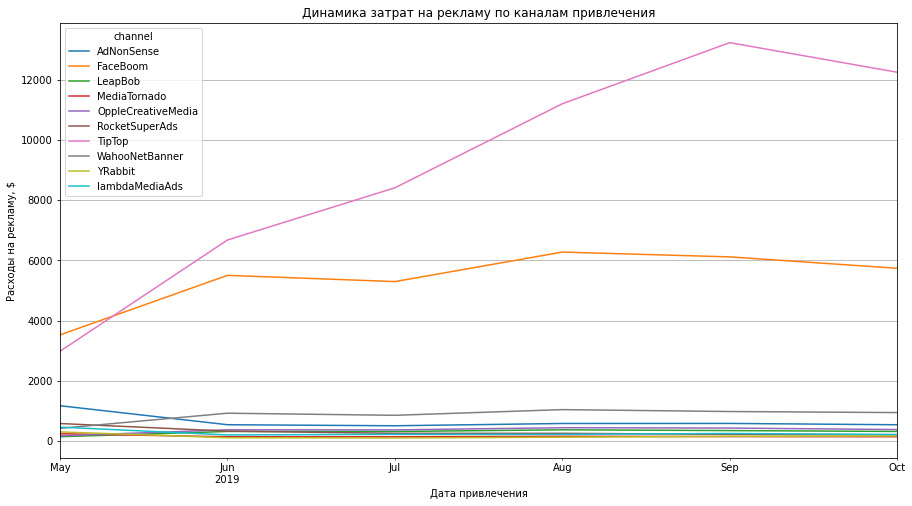

In [67]:
profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(15, 8))
plt.ylabel('Расходы на рекламу, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на рекламу по каналам привлечения')
plt.show()

Из графика видно, что компания активно вкладывала в рекламу на канале TipTop, причем каждый месяц расходы росли. На канал FaceBoom расходы оставались примерно на одном уровне и составляли примерно 6000$ в месяц. На остальные каналы затраты на рекламу минимальны.

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC (стоимость привлечения клиента) на одного пользователя для всего проекта и для каждого источника трафика.

In [68]:
print('Средняя стоимость привлечения одного клиента: ', round(profiles['acquisition_cost'].mean(),3))
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False)

Средняя стоимость привлечения одного клиента:  1.127


,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Выводы:**
- Самые большие расходы на рекламу в канале TipTop, при этом доля платящих пользователей не самая высокая (по рейтингу только 4-я). 
- Самая высокая доля платящих пользователей приходит с канала FaceBoom, причем затраты на рекламу почти в два раза меньше, чем на канале TipTop.
- Средняя стоимость привлечения одного клиента на канале TipTop в 2,5 раза выше средней. Возможно стоит пересмотреть распределение расходов на рекламу в данный канал.

## Шаг 5. Оценка окупаемости рекламы

Установим момент и горизонт анализа данных. Предположим, что на календаре 1 ноября 2019 года. В бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, поэтому и горизонт анализа зададим в 2 недели.

In [69]:
observation_date = datetime(2029, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Проанализируем общую окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции `get_ltv()` и `plot_ltv_roi()`.

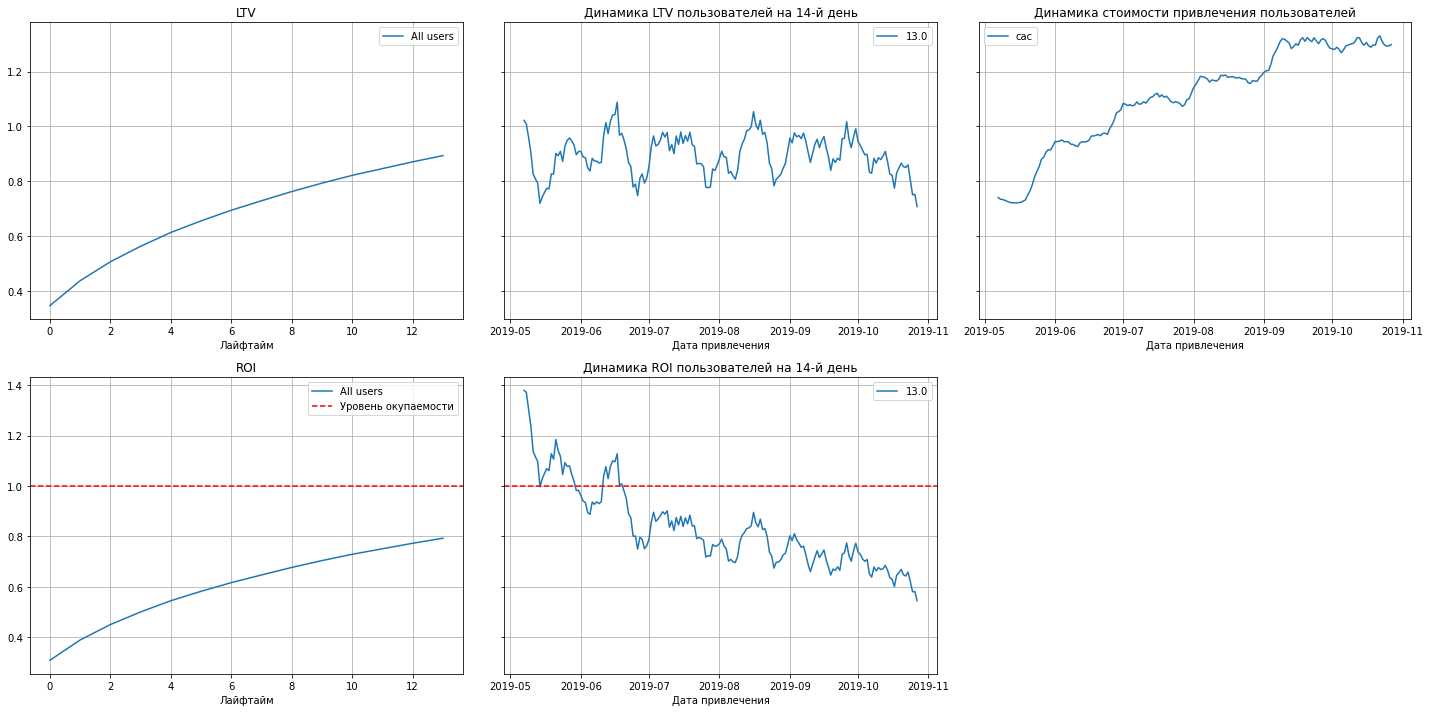

In [70]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:
- Реклама не окупается. ROI достигает отметки 80%.
- CAC растет. Это неудивительно, так как расходы на рекламу росли на протяжении всего периода.
- LTV стабилен.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

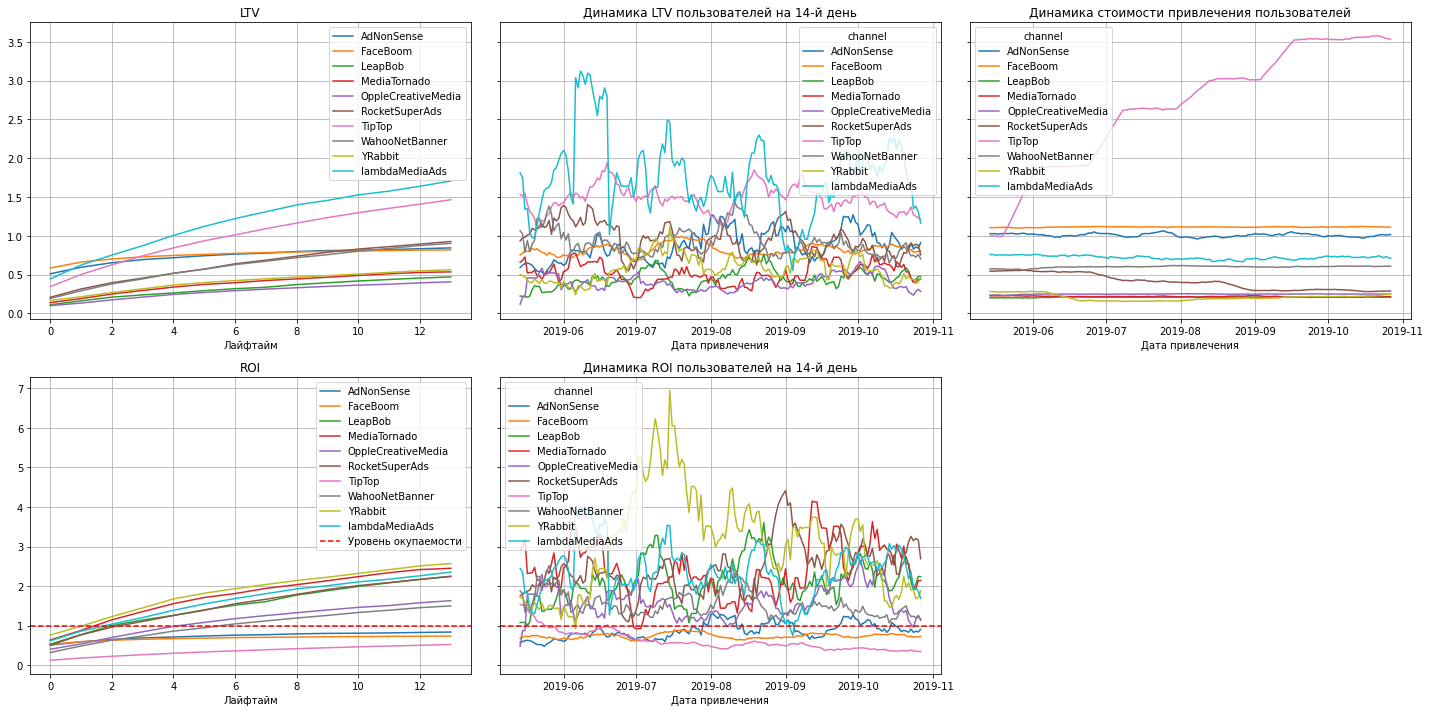

In [71]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать следующие выводы:

- Большинство рекламных площадок окупает себя. Не окупают себя: TipTop, FaceBoom и AdNonSence.
- Динамика стоймости привлечения пользователей стабильная, за исключением канала TipTop. Здесь наблюдается сильный рост расходов. Возможно это и является причиной убытков компании.


Далее проанализируем окупаемость рекламы с разбивкой по странам. Для этого построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

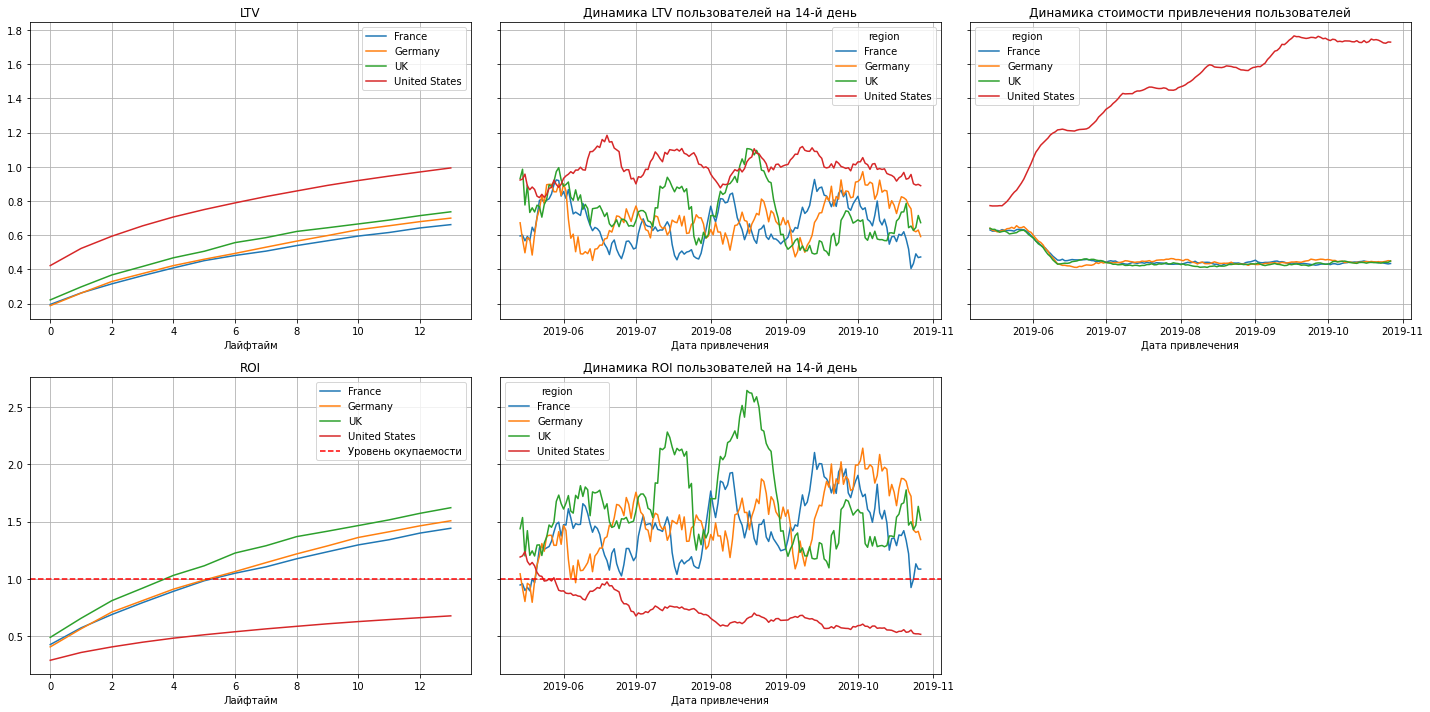

In [72]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать следующие выводы:
- Реклама не окупается только в США.
- Наблюдается рост стоимости привлечения пользователей из США, когда как в других странах в начале наблюдается небольшое падение, потом всё стабильно. Скорее всего канал привлечения таких пользователей - TipTop.
- LTV стабилен. И тут США лидирует, так как доля платящих пользователей самый высокий, по сравнению с другими странами.

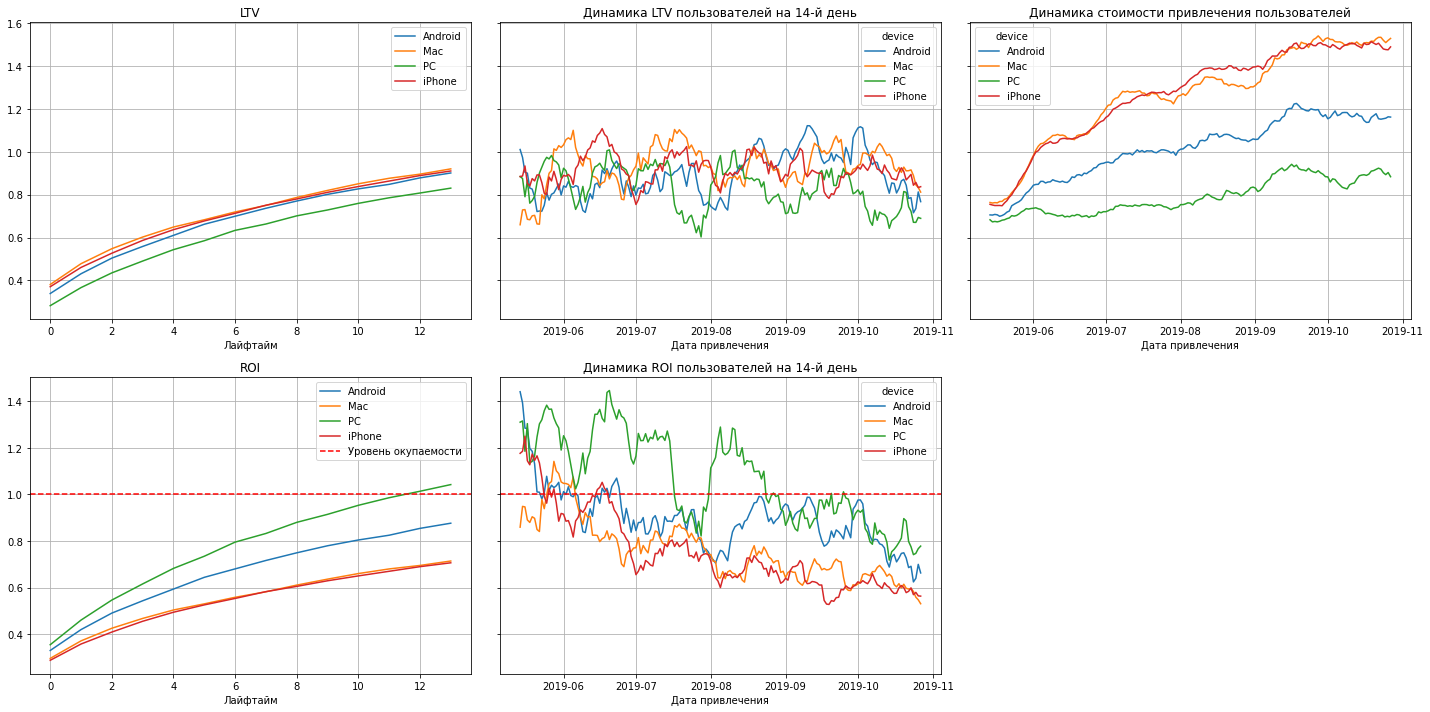

In [73]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать следующие выводы:
- Реклама на iPhone, Mac и Android не окупается.
- Самый большой рост стоимости привлечения пользователей на устройствах iPhone и Mac. У пользователей Android и PC рост медленнее.
- LTV стабилен. 

Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

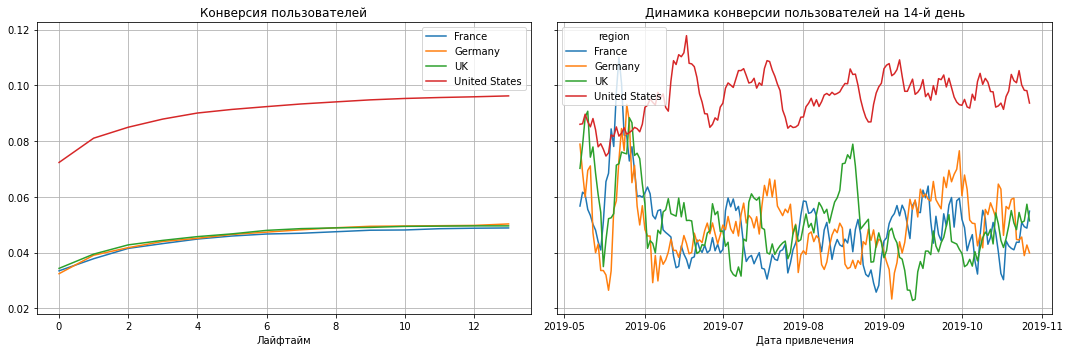

In [74]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

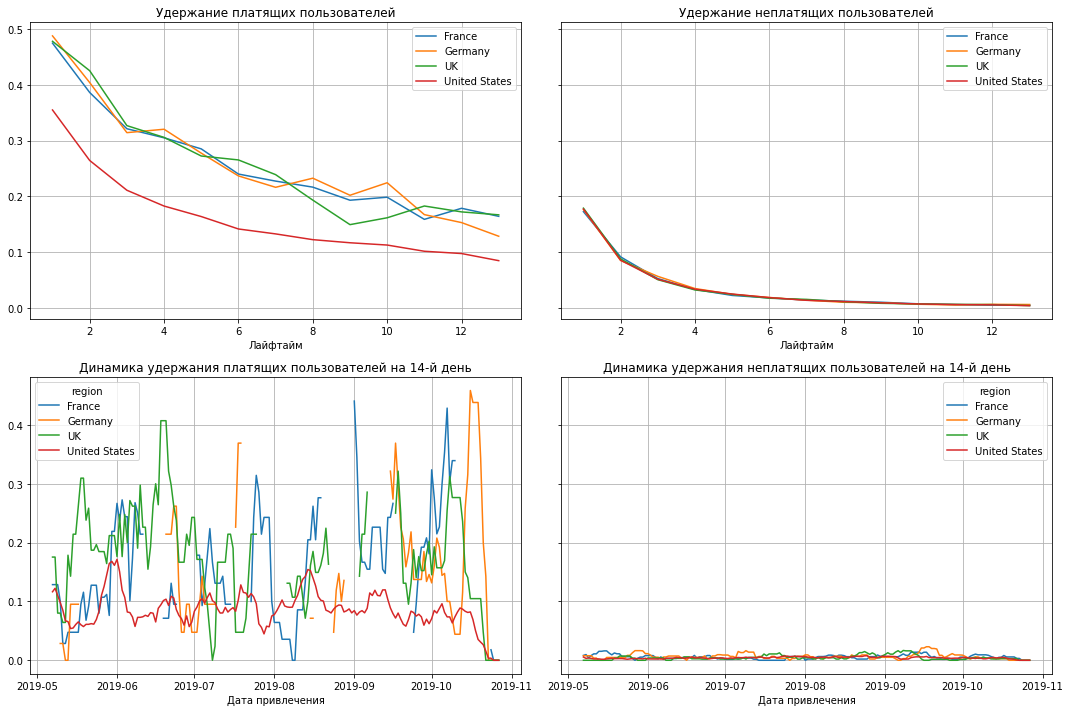

In [75]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конверсия стабильна, самая высокая у пользователей из США. Однако удержание ниже чем в других странах.

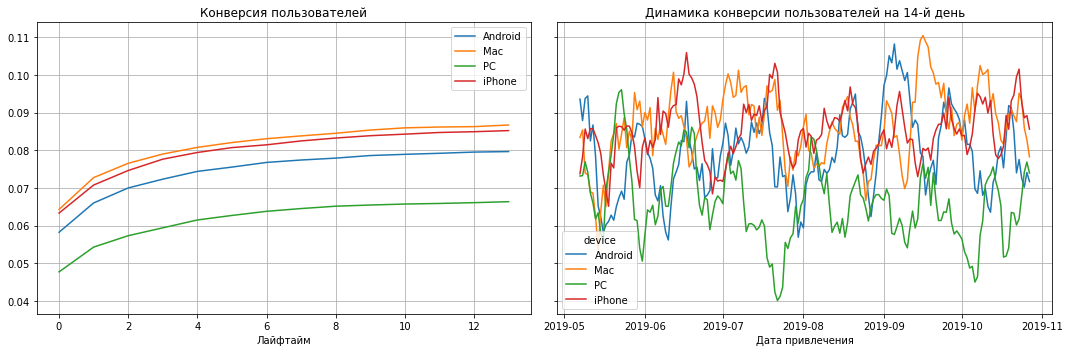

In [76]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

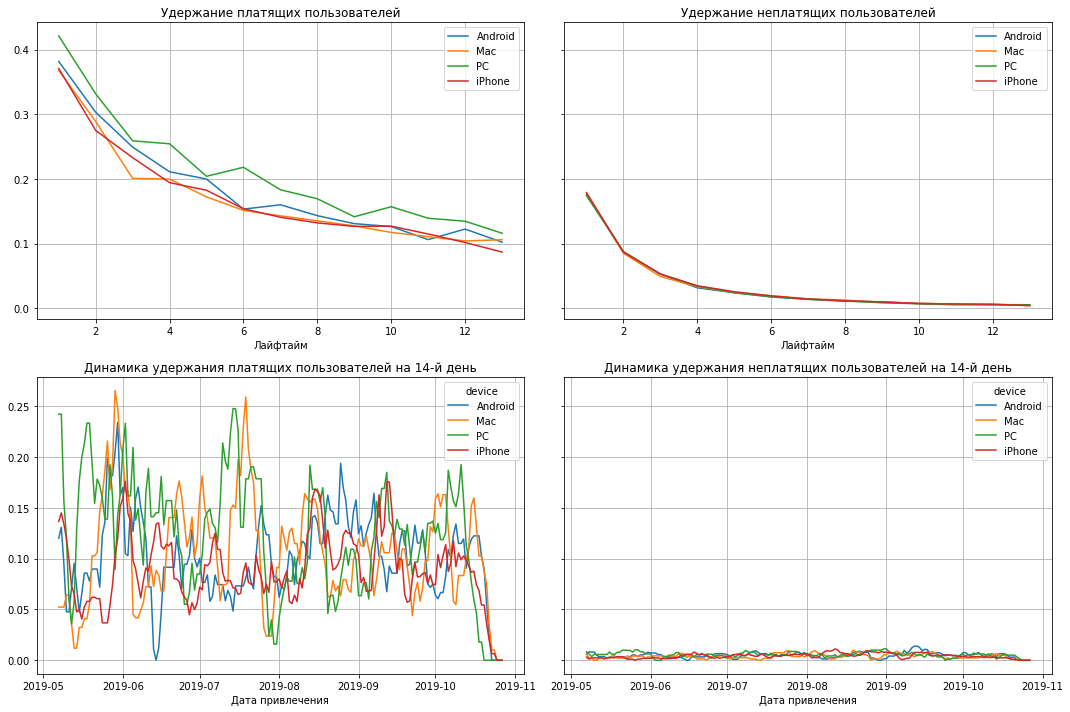

In [77]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конверсия также стабильна, самая большая у пользователей Mac и iPhone (большинство таких устройств приходится на пользователей из США). Android чуть-чуть отстает.

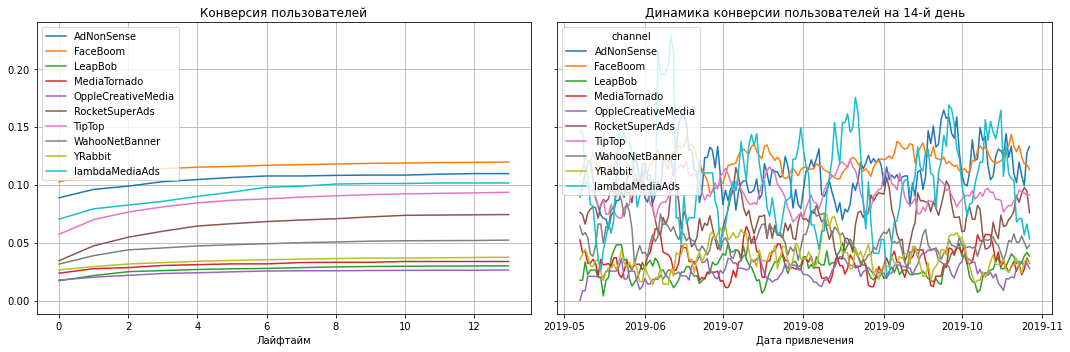

In [78]:
# смотрим конверсию с разбивкой по рекламным каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

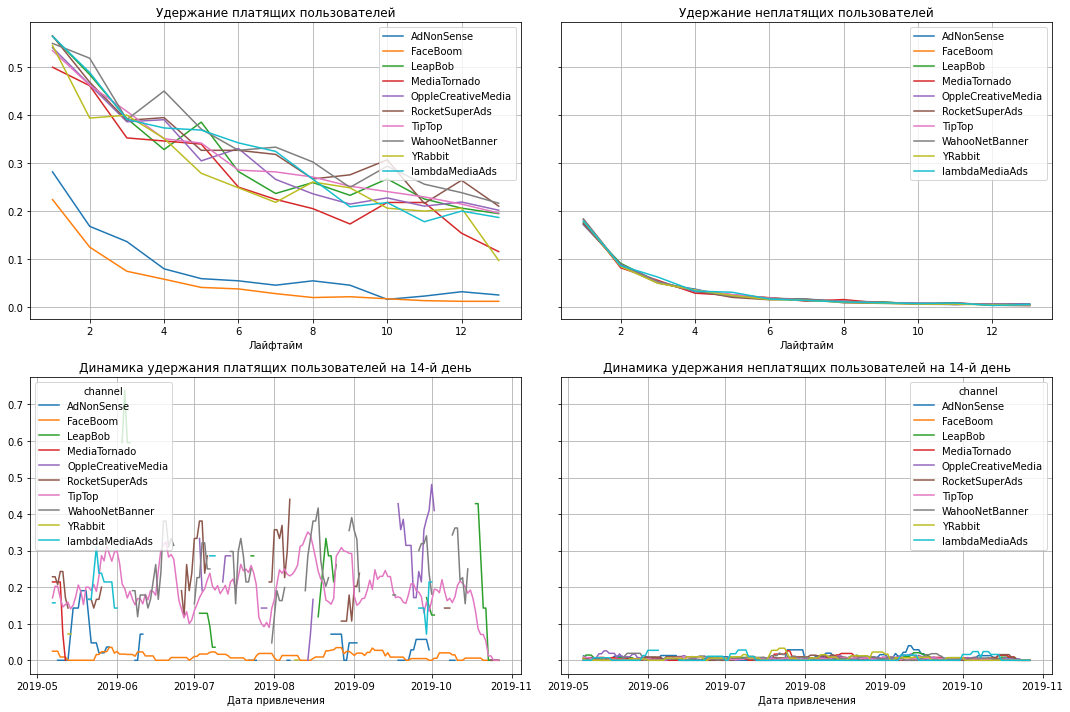

In [79]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Для пользователей, пришедших с каналов FaceBoom и AdNonSence конверсия стабильна, а вот показатель удержания очень низкий по сравнению с остальными каналами. График динамики удержания платящих пользователей имеет обрывы, что говорит об отсутствии пользователей в данный период.


Промежуточные итоги:
- Реклама не окупается.
- Окупаемость рекламы снижают пользователи из США и клиенты, пришедшие с каналов FaceBoom, TipTop и AdNonSence.
- Одна из причин - высокие расходы на рекламу. Так средняя стоимость клиента с канала TipTop составляет 2,8 долл., когда как среднее значение по всем каналам 1,1 долл. Вероятнее всего, через данный канал в основном приходят пользователи из США, что и объясняет нузкую окупаемость рекламы данной страны. Стоит пересмотреть стратегию распределения расходов на рекламу.
- Вторая - низкое удержание пользователей с каналов FaceBoom и AdNonSence. 

Проверим с каких каналов привлекаются пользователи из США:

In [80]:
region_client = profiles.pivot_table(index='channel', columns='region', values='user_id', aggfunc='nunique')
region_client

region,France,Germany,UK,United States
channel,,,,
AdNonSense,1366.0,1219.0,1295.0,NaN
FaceBoom,NaN,NaN,NaN,29144.0
LeapBob,2988.0,2519.0,3046.0,NaN
MediaTornado,NaN,NaN,NaN,4364.0
OppleCreativeMedia,2991.0,2562.0,3052.0,NaN
RocketSuperAds,NaN,NaN,NaN,4448.0
TipTop,NaN,NaN,NaN,19561.0
WahooNetBanner,2971.0,2579.0,3003.0,NaN
YRabbit,NaN,NaN,NaN,4312.0


Что и требовалось доказать! Каналы TipTop и FaceBoom ориентированы только на пользователей из США, что и объясняет низкую окупаемость рекламы и низкие показатели удержания клиентов в этой стране.

## Шаг 6. Общий вывод

Цель проекта - определить причины убытков компании и помочь ей выйти в плюс. В начале исследования была проведена подготовка данных к анализу, а именно, значения в таблицах приведены к нужному типу данных, проверено наличие дубликатов в таблицах. Для выполнения задачи, необходимо было создать пользовательские профили и на их основе, с использование бизнес метрик выявить причины убытка компании. Проведенный анализ показал, что основная причина убытка - высокие расходы на рекламу, а именно на такие рекламные источники как TipTop и FaceBoom. Реклама на данных каналах не окупается, хоть и показатели доли платящих клиентов там выше, чем на других каналах. Еще одна причина - низкое удержание пользователей каналов FaceBoom и AdNonSense.

Рекмендации отделу маркетинга:
- Пересмотреть распределение рекламного бюджета, уменьшить расходы на каналы TipTop и FaceBoom.
- Обратить внимание на перспективный европейский канал lambdaMediaAds. Данный рекламный источник имеет хорошие показатели доли платящих пользователей и самый высокий показатель "пожизненной ценности" клиента. Возможно здесь стоит увеличить рекламные расходы.